## Techical stuff

Import libraries and functions that will be used below:

In [27]:
#Working with files and reading RSS XML's
import os
import feedparser

#These are very useful for data analysis!
import numpy as np
import pandas as pd

#This is for working with raw Russian texts
import pymorphy2
import nltk
import re

##This is for talking to the web
#import requests
#import ratelimit
#import json
#from bs4 import BeautifulSoup
#import unicodedata


#This is for us to create a word cloud
import wordcloud
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

#Text vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#Text clustering
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.manifold import MDS
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN

#Networks
import transliterate
import networkx as nx
import gc

#Progress bars
from tqdm import tqdm_notebook as tqdm

from operator import itemgetter

Also make a function (technically, a generator) that will provide us with articles from a folder with RSS XML files:

In [3]:
#Generator function that gives out articles one by one
def articleGenerator(folderPath):
    #Get names of all files in the target folder
    files = os.listdir(folderPath)
    for file in files:
        
        #If the current file is not an XML, we skip it
        #and go to the next one
        if not file.endswith(".xml"):
            continue
        
        #Create a full path to the file
        fullPath = folderPath + "/" + file
        print("Reading file", fullPath)
        
        #Parse the file using the feedparser library
        feed = feedparser.parse(fullPath)
        
        #If feed.bozo is not 0, this means that persing has failed
        #somehow. However, we technically can continue parsing,
        #so we just alert the user and go on
        if feed.bozo != 0:
            print("FAILED TO PARSE XML CORRECTLY!")
            print(feed.bozo_exception)
            print(feed.bozo_exception.getMessage())
        
        #For each entry in the feed, we yield the full text
        #contained in .summary
        for item in feed.entries:
            yield item.summary

## Loading and preprocessing texts

We use the function from above to make a list of texts from the current folder (which contains 1 XML with 1000 articles in it):

In [7]:
texts = [text for text in articleGenerator(".")]
texts[0]

Reading file ./20_02_2019_13_36_08.xml


'стр. 1:  Яков Миркин: Надо наращивать личное потребление, чтобы всем дольше жить  Учителей наконец избавят от составления бесконечных отчетов. Новый законопроект снизит «бумажную» нагрузку на педагогов...\nстр. 2:  События и комментарии  2 События и комментарии  FACEBOOK.COM /www.rg.ru TWITTER.COM /rgrus rg.ru  ODNOKLASSNIKI.RU /rg.ru VK.COM /rgru Российская газета www.rg.ru 19 февраля 2019...\nстр. 3:  Российская газета www.rg.ru 19 февраля 2019 вторник № 36 (7794)  События и комментарии rg.ru  FACEBOOK.COM /www.rg.ru  ODNOKLASSNIKI.RU /rg.ru  TWITTER.COM /rgrus...\nPDF-версия документа доступна в системе Public.ru. Для просмотра авторизуйтесь в системе и перейдите по ссылке http://search.public.ru/show_doc_win.pu?query=1507183&doc=274758718'

This one long string is not very usable for analysis, it also contains a lot of stuff that is essentially meaningless.

We need to extract some units of information that will be useful for further analysis. This process is known as tokenization. Here, I use a regular expression to extract sequences of cyrillic and latin letters that are 1 letter long or longer. This tokenizer also strips punctuation and numbers from the text:

In [12]:
#tokenizer = nltk.tokenize.RegexpTokenizer("\w+")
tokenizer = nltk.tokenize.RegexpTokenizer("[а-яА-Яa-zA-Zёй]+")
tokenizedTexts = [tokenizer.tokenize(text) for text in tqdm(texts)]
"|".join(tokenizedTexts[0])

'стр|Яков|Миркин|Надо|наращивать|личное|потребление|чтобы|всем|дольше|жить|Учителей|наконец|избавят|от|составления|бесконечных|отчетов|Новый|законопроект|снизит|бумажную|нагрузку|на|педагогов|стр|События|и|комментарии|События|и|комментарии|FACEBOOK|COM|www|rg|ru|TWITTER|COM|rgrus|rg|ru|ODNOKLASSNIKI|RU|rg|ru|VK|COM|rgru|Российская|газета|www|rg|ru|февраля|стр|Российская|газета|www|rg|ru|февраля|вторник|События|и|комментарии|rg|ru|FACEBOOK|COM|www|rg|ru|ODNOKLASSNIKI|RU|rg|ru|TWITTER|COM|rgrus|PDF|версия|документа|доступна|в|системе|Public|ru|Для|просмотра|авторизуйтесь|в|системе|и|перейдите|по|ссылке|http|search|public|ru|show|doc|win|pu|query|doc'

Russian is an inflected language. This means that words can change based on their role and position in sentences. This presents a problem for automated analysis, simply because different forms of the same word are different to a computer.

However, we have algoritms that either allow us to identify the stem (основа) of a word (it doesn't change), or take a word and put it into its normal form (начальная форма). There are many such algorithms and even more implementations. In this seminar, I use pymorphy2 to put the words into their normal form, because I like this approach and because the library is free, open source and portable: 

In [13]:
morphA = pymorphy2.MorphAnalyzer()
normalizedTexts = []
for tokens in tqdm(tokenizedTexts):
    normalizedText = [morphA.parse(token)[0].normal_form for token in tokens]
    normalizedTexts.append(normalizedText)
"|".join(normalizedTexts[0])

'страница|яков|миркина|надо|наращивать|личный|потребление|чтобы|весь|долгий|жить|учитель|наконец|избавить|от|составление|бесконечный|отчёт|новый|законопроект|снизить|бумажный|нагрузка|на|педагог|страница|событие|и|комментарий|событие|и|комментарий|facebook|com|www|rg|ru|twitter|com|rgrus|rg|ru|odnoklassniki|ru|rg|ru|vk|com|rgru|российский|газета|www|rg|ru|февраль|страница|российский|газета|www|rg|ru|февраль|вторник|событие|и|комментарий|rg|ru|facebook|com|www|rg|ru|odnoklassniki|ru|rg|ru|twitter|com|rgrus|pdf|версия|документ|доступный|в|система|public|ru|для|просмотр|авторизоваться|в|система|и|перейти|по|ссылка|http|search|public|ru|show|doc|win|pu|query|doc'

Still, some words in the text are meaningless, like сonjunctions (союзы), prepositions (предлоги) and so on. We also have some word that carry no meaning out of context and thus are not useful for bag-of-words based methods.

In order to make our analysis more efficient, we can remove them. Here, we do it using a list of stopwords for Russian and English laguages that I have collected over some time. These lists for different languages come bundled with different libraries for text analysis or can be found with Google.

In [14]:
stopwords = open("stopwords.txt", encoding="utf8").read().split()
stopwords = set(stopwords)

swTexts = []
for words in tqdm(normalizedTexts):
    goodWords = [word for word in words if word not in stopwords]
    swTexts.append(goodWords)
"|".join(swTexts[0])

'страница|яков|миркина|надо|наращивать|личный|потребление|долгий|жить|учитель|наконец|избавить|составление|бесконечный|отчёт|новый|законопроект|снизить|бумажный|нагрузка|педагог|страница|событие|комментарий|событие|комментарий|facebook|com|www|rg|ru|twitter|com|rgrus|rg|ru|odnoklassniki|ru|rg|ru|vk|com|rgru|российский|газета|www|rg|ru|февраль|страница|российский|газета|www|rg|ru|февраль|вторник|событие|комментарий|rg|ru|facebook|com|www|rg|ru|odnoklassniki|ru|rg|ru|twitter|com|rgrus|pdf|версия|документ|доступный|система|public|ru|просмотр|авторизоваться|система|перейти|ссылка|http|search|public|ru|show|doc|win|pu|query|doc'

## Feature extraction (text vectorization)

Even though we have greatly simplified the texts we had, a lot of traditional data analysis methods are not applicable. We probably could have used some deep learning approaches to extract some from those texts as is, but this is way outside the scope of the seminar and the course.

So, if we want to apply traditional methods to this kind of data, we must first convert it into numbers. This process is called feature extraction.

One of the simplest and most widespread methods of feature extraction for text data is building a Document-Term matrix, where columns are different words and rows are documents. Those matrices are huge, but can be stored efficiently.

The numbers in the cells can be calculated using different approaches, which we will discuss below.

The first approach we are going to use is to just calculate of many times every word is mentioned in every document. This is very simple yet effective, and actually used a lot in the real world!

In [15]:
dtm1fact = CountVectorizer()
dtm1 = dtm1fact.fit_transform([" ".join(text) for text in swTexts])
"%d documnets, %d terms" % dtm1.shape

'1000 documnets, 19184 terms'

In [39]:
dtm1

<1000x19184 sparse matrix of type '<class 'numpy.int64'>'
	with 208897 stored elements in Compressed Sparse Row format>

We can now sum up the columns of the matrix, and obtain a list of words that are mentioned the most in the whole corpus. This can be used as a measuremnt of an overall importance of a word. Here I show the 10 most important words in our corpus according to this metric

In [16]:
wordfreq = pd.DataFrame(np.sum(dtm1, axis=0).T, index=dtm1fact.get_feature_names(), columns = ['count'])
wordfreq.sort_values(by=['count'], ascending=False).head(10)

,count
год,3720
общественный,1957
россия,1925
организация,1816
проект,1638
общество,1616
человек,1509
развитие,1457
гражданский,1400
российский,1361


However, this is a little too simple sometimes, as it's biased toward words that are mentioned a lot, but do not carry a lot of meaning. We want to identify the most meaningful words, not the most frequent.

The usual approach to demote words that are mentioned in a lot of texts is TF-IDF scoring. For each word and each document, we calculate how much the word is mentioned in this document and then divide it by how much it appears in the whole corpus. This lowers the scores for words that are mentioned a lot across the corpus, but not much in each document.

In [17]:
dtm2fact = TfidfVectorizer()
dtm2 = dtm2fact.fit_transform([" ".join(text) for text in swTexts])
"%d documnets, %d terms" % dtm2.shape

'1000 documnets, 19184 terms'

Summing up the scores is not very meaningful, however, we can find a mean score for each word and use it as a measure of overall importance

In [18]:
wordtfidf = pd.DataFrame(np.mean(dtm2, axis=0).T, index=dtm2fact.get_feature_names(), columns = ['score'])
wordtfidf.sort_values(by=['score'], ascending=False).head(10)

,score
год,0.040573
конкурс,0.034017
проект,0.031069
общественный,0.026017
организация,0.025692
грант,0.024475
область,0.023602
ru,0.022786
россия,0.022424
развитие,0.022127


A good way to visualize these scores is a word cloud

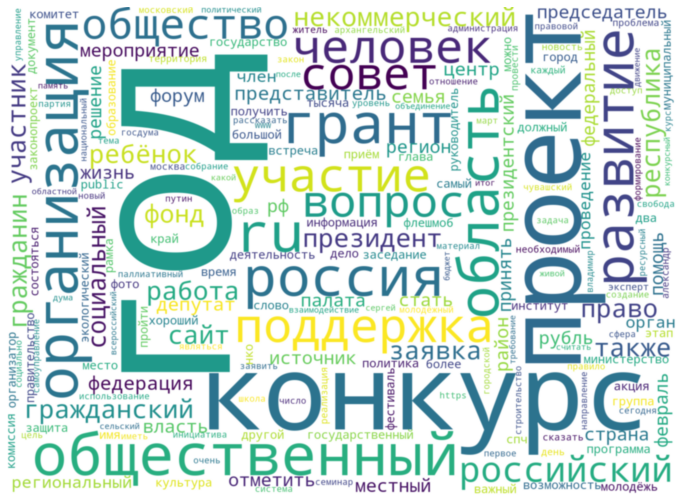

In [19]:
#Now we can use the scores from above 
#to make a good-looking word cloud

cloud1 = wordcloud.WordCloud(background_color="white", width = 4*400, height = 3*400)
cloud1.fit_words(wordtfidf.to_dict()["score"])

plt.figure(figsize = (4*3, 3*3))
plt.axis("off")
plt.imshow(cloud1, interpolation="bicubic", aspect='auto')

In [35]:
WORD_MIN_LEN = 5

phrases = []
for text in tqdm(normalizedTexts):
    mla = []
    for l in text:
        if (l in stopwords) or (len(l) <= WORD_MIN_LEN):
            mla.append("|")
        else:
            mla.append(l)

    phrasea = [phrase.strip().split(" ") for phrase in (" ".join(mla)).split("|") if phrase.strip() != ""]
    phrases.append(phrasea)
phrases[0]

[['страница'],
 ['миркина'],
 ['наращивать', 'личный', 'потребление'],
 ['долгий'],
 ['учитель', 'наконец', 'избавить'],
 ['составление', 'бесконечный'],
 ['законопроект', 'снизить', 'бумажный', 'нагрузка'],
 ['педагог', 'страница', 'событие'],
 ['комментарий', 'событие'],
 ['комментарий', 'facebook'],
 ['twitter'],
 ['odnoklassniki'],
 ['российский', 'газета'],
 ['февраль', 'страница', 'российский', 'газета'],
 ['февраль', 'вторник', 'событие'],
 ['комментарий'],
 ['facebook'],
 ['odnoklassniki'],
 ['twitter'],
 ['версия', 'документ', 'доступный'],
 ['система', 'public'],
 ['просмотр', 'авторизоваться'],
 ['система'],
 ['перейти'],
 ['ссылка'],
 ['search', 'public']]

In [36]:
word_frequency = dict()
word_degree = dict()
word_score = dict()

for text in tqdm(phrases):
    for phrase in text:
        phrase_len = len(phrase)
        phrase_degree = phrase_len - 1
        for word in phrase:
            if word not in word_frequency:
                word_frequency[word] = 0
            word_frequency[word] += 1

            if word not in word_degree:
                word_degree[word] = 0
            word_degree[word] += phrase_degree

for word in word_frequency:
    word_degree[word] += word_frequency[word]

for word in word_frequency:
    word_score[word] = word_degree[word] / word_frequency[word]
    
sorted(word_score.items(), key=itemgetter(1), reverse=True)[0:10]
    


[('архивист', 49.0),
 ('кореец', 49.0),
 ('космонавтика', 49.0),
 ('кекусинкай', 49.0),
 ('гандбол', 37.5),
 ('ревматолог', 34.0),
 ('офтальмолог', 34.0),
 ('гемофилия', 34.0),
 ('благоденствие', 27.666666666666668),
 ('кинорежиссёр', 27.0)]

In [37]:
MAX_PHRASE_LEN = 50
keyword_candidates = dict()
for text in tqdm(phrases):
    for phrase in text:
        sPhrase = " ".join(phrase)
        
        if len(sPhrase) > MAX_PHRASE_LEN:
            continue
        
        cScore = 0
        for word in phrase:
            cScore += word_score[word]
        keyword_candidates[sPhrase] = cScore
sorted(keyword_candidates.items(), key=itemgetter(1), reverse=True)

[('региональный отделение политический партия партия', 46.34795368685445),
 ('интервью кинорежиссёр григорий чухрая заметить', 45.50026164311878),
 ('глухой общероссийский общественный организация', 41.13385285664624),
 ('политический партия российский партия пенсионер', 40.4049901890171),
 ('региональный отделение политический партия против', 39.87017777675936),
 ('алтайский краевой общественный организация ветеран', 39.82526437721706),
 ('всероссийский политический партия партия', 37.84751067269671),
 ('региональный отделение партия справедливый россия', 37.35601784946556),
 ('хорошо общественный организация алтайский краевой', 36.81649244739249),
 ('немецкий историк хартмут рубнер hartmut rubner', 36.207729468599034),
 ('источник политический партия патриот россия', 36.00087921573526),
 ('региональный отделение политический партия', 35.91759156986281),
 ('бизнес общественный организация профсоюз работник', 35.52273128151462),
 ('женщина россия всероссийский общественный движение', 3

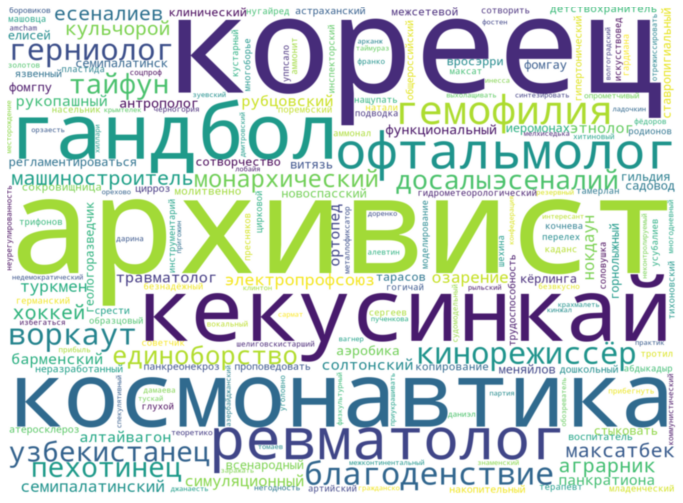

In [38]:
#Now we can use the scores from above 
#to make a good-looking word cloud

cloud2 = wordcloud.WordCloud(background_color="white", width = 4*400, height = 3*400)
cloud2.fit_words(word_score)

plt.figure(figsize = (4*3, 3*3))
plt.axis("off")
plt.imshow(cloud2, interpolation="bicubic", aspect='auto')

## Analysis

We can now apply classical methods of analysis to this matrix we have constructed. You can do a lot with this, like dimensinality reduction (we have a lot of dimensions), different types of regression, classification and so on.

Here, we are going to use diffrent methods to cluster our texts, since this is relatively easy to do and easy to demonstrate. However, note that this is definitely not the only thing you can do, it's just my favourite!

First, let's construct a distance matrix of our document and show it on a plot using MDS to create a 2 dimensional embedding.

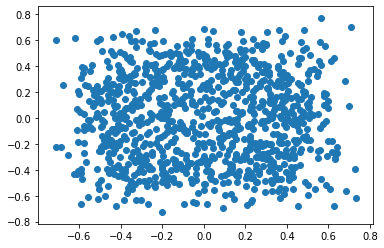

In [40]:
#We can treat words (columns of the DTM)
#as variables and documnents as observations
#We can compute pairwise distances between them
#Since they are actually in a multidimensional space
#we cannot plot them as is. We can, however, use MDS
#to construct a 2D approximation which we can plot

dist = pairwise_distances(dtm2, metric = "cosine")
distEmbed = MDS(dissimilarity='precomputed', metric=False)
distCoords = distEmbed.fit_transform(dist)

plt.axis("on")
plt.scatter(distCoords[:,0], distCoords[:,1])

First, we try to cluster our texts using K-means. We first find the number of clusters we need to use, and then we construct the actual clustering:

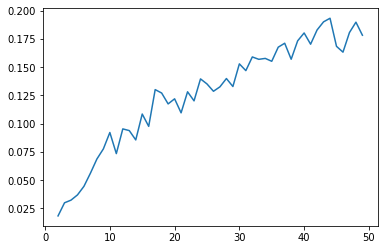

In [41]:
#K-Means needs to know the number of clusters in advance
#I don't know how much clusters there are in the data
#so I try different numbers (from 2 to 49) and then
#calculate mean silhouette score, which is a kind
#of a goodness of fit measure for clustering
cluNums = []
cluScores = []
for nc in tqdm(range(2, 50)):
    clustT = MiniBatchKMeans(n_clusters = nc)
    clustersT = clustT.fit_predict(dtm2)
    scoreT = silhouette_score(dtm2, clustersT)
    cluNums.append(nc)
    cluScores.append(scoreT)
plt.plot(cluNums, cluScores)

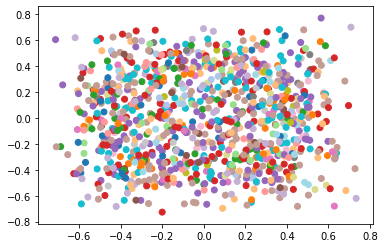

In [42]:
#Now we can build the actual clustering using the
#number of clusters we found above and then show different
#clusters with different colors
clust = MiniBatchKMeans(n_clusters = 40)
clusters = clust.fit_predict(dist)
plt.axis("on")
plt.scatter(distCoords[:,0], distCoords[:,1], c=clusters, cmap="tab20")

In [43]:
#Show number of documents in each cluster
#in this clustering
clusterN, counts = np.unique(clusters, return_counts=True)
dict(zip(clusterN, counts))

{0: 9,
 1: 23,
 2: 17,
 3: 5,
 4: 19,
 5: 25,
 6: 11,
 7: 62,
 8: 22,
 9: 23,
 10: 9,
 11: 20,
 12: 98,
 13: 15,
 14: 14,
 15: 12,
 16: 117,
 17: 28,
 18: 16,
 19: 32,
 20: 16,
 21: 6,
 22: 11,
 23: 159,
 24: 9,
 25: 17,
 26: 9,
 27: 9,
 28: 5,
 29: 7,
 30: 9,
 31: 7,
 32: 6,
 33: 7,
 34: 8,
 35: 12,
 36: 99,
 37: 7,
 38: 2,
 39: 18}

In [48]:
#Show a random text from a cluster
#using clustering created by K-Means
cluster = 23
textN = np.random.choice(np.where(clusters == cluster)[0], 3)[0]
texts[textN]

'Европейский комиссар по бюджету и человеческим ресурсам Гюнтер Эттингер возложил цветы к Монументу Победы и встретился с правозащитниками во время визита в Минск. Об этом передает пресс-служба Представительства ЕС в Беларуси. В ходе встречи Эттингер подчеркнул роль активного гражданского общества в обеспечении социально-экономического благосостояния страны, сообщает Представительство ЕС в Беларуси. Как отметил глава правозащитного центра «Весна» Алесь Беляцкий, на встрече присутствующие «обсудили ситуацию с правами человека в Беларуси, а также трудности, которые белорусские власти создают в работе гражданских организаций». Правозащитник также обратил внимание Еврокомиссара на то, что любое финансирование должно обуславливаться определенными условиями. «Финансовая помощь Евросоюза не должна быть безусловной. Мы ожидаем от белорусских властей системных изменений в ситуации с правами человека, с демократическими принципами в Беларуси и справедливым судом», - подчеркнул Алесь Беляцкий. На

Now, this algorithm definitely isn't the best. We can also use different methods that work well with multidimensional data and (in my experience) work better for text analysis.

One of such methods is DBSCAN, which identifies dense regions of space and puts points in those regions in the same cluster. This method is very scalable, and it can also identify points that do not belog to any cluster.

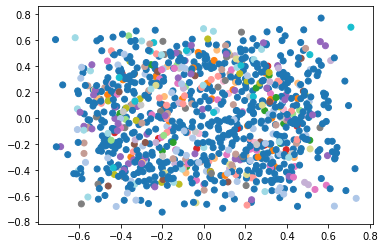

In [49]:
#Use another algorithm for clustering
#DBSCAN is a good one, since it's density
#based and also can find points that don't
#fit into any cluster
clustNP = DBSCAN(eps = 0.5, metric = "precomputed")
clustersNP = clustNP.fit_predict(dist)
plt.scatter(distCoords[:,0], distCoords[:,1], c=clustersNP, cmap="tab20")

In [50]:
#Show number of documents in each cluster
#in this new clustering
#Cluster -1 means that the point (document) was
#classified as noice
clusterNNP, countsNP = np.unique(clustersNP, return_counts=True)
dict(zip(clusterNNP, countsNP))

{-1: 583,
 0: 19,
 1: 9,
 2: 61,
 3: 17,
 4: 7,
 5: 6,
 6: 7,
 7: 9,
 8: 5,
 9: 5,
 10: 5,
 11: 9,
 12: 9,
 13: 17,
 14: 23,
 15: 25,
 16: 9,
 17: 5,
 18: 7,
 19: 9,
 20: 20,
 21: 8,
 22: 8,
 23: 19,
 24: 6,
 25: 15,
 26: 6,
 27: 5,
 28: 5,
 29: 10,
 30: 6,
 31: 6,
 32: 5,
 33: 6,
 34: 5,
 35: 14,
 36: 10}

In [56]:
#Show a random text from a cluster
#using clustering created by DBSCAN
cluster = 15
textN = np.random.choice(np.where(clustersNP == cluster)[0], 3)[0]
texts[textN]

'Для участия во флешмобе необходимо зарегистрироваться на платформе ecowiki.ru/consumeresponsibly и выполнить ряд несложных заданий с помощью инструкций, подготовленных организаторами:\n- рассказывает руководитель проекта “Эковики” Александр Титов.\nФлешмоб “Потребляй с умом” стартовал на портале Ecowiki.ru - платформе открытых знаний и технологий для популяризации экологичного образа жизни и развития экологического сообщества России. В течение 2019 года на платформе будет запущено 10 флешмобов, самых активных участников которых ждут полезные экопризы. Участниками первого флешмоба проекта - “Хранители птиц” - стали более 2 тысяч россиян.\nПроект реализуется с использованием гранта Президента Российской Федерации на развитие гражданского общества, предоставленного Фондом президентских грантов.\nПресс-секретарь Движения ЭКА\nЕвгения Савина'

In [57]:
#Amount of words to use to build the network
nWords = 500

#Find the score for each word (here we use mean TF-IDF)
#then find the indices of nWords with the highest scores
meanScores = np.array(np.mean(dtm2, axis=0)).flatten()
wordIndices = meanScores.argsort()[-nWords:][::-1]

#Create a list of the most important words
#using their indices we found above
wordNames = np.array(dtm2fact.get_feature_names())[wordIndices].tolist()

#We can also transliterate them, and sometimes we need to do it
#because export to pajek is broken right now, and using only
#latin letters for node names makes things much simpler
#Uncomment the following 2 lines to transliterate:
#wordNames = [transliterate.translit(word, language_code='ru', reversed=True) for word in wordNames]
#wordNames = [re.sub(r'\W+', '', word) for word in wordNames]

#Create a submatrix of the whole TF-IDF DTM
#keeping all the documents, but only the most
#important words (using the indices from above)
wordMatrixShrunk = dtm2[:,wordIndices].todense()

#This matrix can be treated as a 2 mode network
#However, in this example I want only the connections between words
#so I multiply the matrix by its transpose to obtain a 
#1-mode network of words
wordNetM = np.matmul(wordMatrixShrunk.T, wordMatrixShrunk)

#By default, NetworkX only uses numbers as node names
#To get meaningful names for our nodes, we create a dictionary
#that maps numbers into their respective words
nodeNamesMap = dict(zip(range(0, len(wordNames)), wordNames))

#Now we, convert the matrix into a network
wordNet = nx.from_numpy_matrix(wordNetM)
#and rename the nodes
nx.relabel_nodes(wordNet, nodeNamesMap, copy = False)

#Uncomment if you want to export the resulting network to Pajek format
#nx.write_pajek(wordNet, "wordnetS.net")

#We delete the matrix and poke the garbage collector
#to free the used RAM, we keep the resulting network
#though
wordNetM = None
nodeNamesMap = None
gc.collect()

291

In [58]:
#We can use centrality as a measure of importance
#Here, I calculate closeness centrality
#and list the 15 most important words by this measure

#Calculate centrality and create a data frame
centDict = nx.closeness_centrality(wordNet)
centDF = pd.DataFrame.from_dict(centDict, orient = "index", columns = ["Cent"])

#Sort itand show the 15 first words
centDF.sort_values(by=["Cent"], ascending=False).head(10)

,Cent
ru,1.000000
российский,0.998000
февраль,0.998000
человек,0.996008
источник,0.996008
также,0.996008
фото,0.996008
гражданский,0.996008
общество,0.996008
год,0.996008


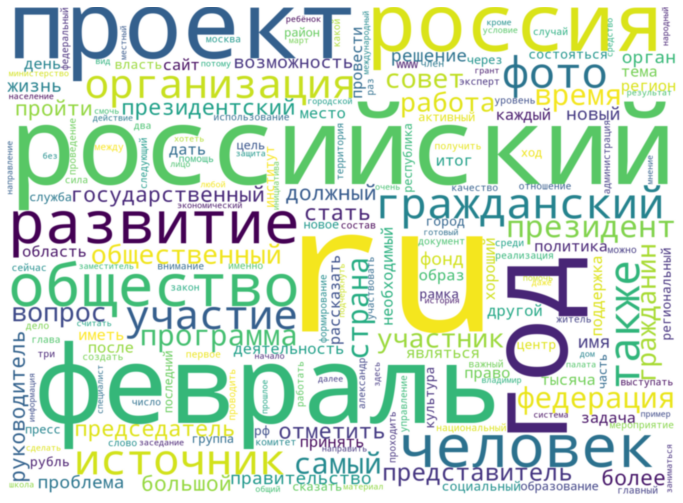

In [60]:
cloud3 = wordcloud.WordCloud(background_color="white", width = 4*400, height = 3*400)
cloud3.fit_words(centDict)

plt.figure(figsize = (4*3, 3*3))
plt.axis("off")
plt.imshow(cloud3, interpolation="bicubic", aspect='auto')